In [1]:
import os
import cv2
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Rescaling, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

In [2]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

np.set_printoptions(suppress=True)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
GRAY_CROPPED_POSITIVES_FOLDER_PATH = '/content/drive/MyDrive/Bundesliga/PositiveFrames/frames_gray_dg/'

In [5]:
img_gen = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    )

In [9]:
class_mode = 'sparse'
seed = 42
target_size = (224, 224)
batch_size = 64

In [10]:
train_data = img_gen.flow_from_directory(
    GRAY_CROPPED_POSITIVES_FOLDER_PATH + 'train',
    class_mode=class_mode, 
    batch_size=batch_size, 
    target_size=target_size,
    seed=seed
    )

Found 2543 images belonging to 3 classes.


In [11]:
valid_data = img_gen.flow_from_directory(
    GRAY_CROPPED_POSITIVES_FOLDER_PATH + 'val', 
    class_mode=class_mode, 
    batch_size=batch_size, 
    target_size=target_size,
    seed=seed
    )

Found 677 images belonging to 3 classes.


In [12]:
test_data = img_gen.flow_from_directory(
    GRAY_CROPPED_POSITIVES_FOLDER_PATH + 'test', 
    class_mode=class_mode, 
    batch_size=batch_size, 
    target_size=target_size,
    seed=seed
    )

Found 652 images belonging to 3 classes.


In [13]:
# next(test_data)[0].shape

In [14]:
filecount = list()
FOLDER = GRAY_CROPPED_POSITIVES_FOLDER_PATH

for set_ in os.listdir(FOLDER):
    for class_ in os.listdir(os.path.join(FOLDER, set_)):
        filecount.append((set_, class_, len(os.listdir(os.path.join(FOLDER, set_, class_)))))

In [36]:
filecount

[('train', 'challenge', 344),
 ('train', 'throwin', 117),
 ('train', 'play', 2082),
 ('val', 'challenge', 94),
 ('val', 'throwin', 22),
 ('val', 'play', 561),
 ('test', 'challenge', 113),
 ('test', 'throwin', 21),
 ('test', 'play', 518)]

### Creating the class weights:

In [51]:
train_events = dict()
for file in filecount:
  if file[0] == 'train':
    train_events[file[1]] = file[2]

total_train_samples = sum(train_events.values())

class_weights = dict()
ordered_events = ['challenge', 'play', 'throwin']
for i, event in enumerate(ordered_events):
  class_weights[i] = total_train_samples / train_events[event]

In [46]:
class_weights

{0: 7.392441860465116, 1: 1.2214217098943323, 2: 21.735042735042736}

In [44]:
# class_weights = dict()

# events = ['challenge', 'play', 'throwin']

# for i, key in enumerate(events):
#   for file_ in filecount:
#     if file_[0] == 'train' and file_[1] == key:
#       class_weights[i] = file_[2]
#       break

# samples = sum(class_weights.values())

# for key in class_weights:
#   class_weights[key] = samples / class_weights[key]

# class_weights

## Defining functions:

In [47]:
def create_model(with_dropout=False):
  vgg_model = VGG16(include_top=False, input_shape=(224, 224, 3))
  if with_dropout:
    model = Sequential([
        vgg_model,
        Dropout(0.5),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(3, activation='softmax')
    ])
  else:
    model = Sequential([
        vgg_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dense(3, activation='softmax')
    ])

  return model

In [48]:
def compile_model(model, lr=0.001):
  """Compiles the model"""
  optimizer = Adam(learning_rate=lr)

  model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics='accuracy',
              )
  return model

In [53]:
def train_model(model, train_data=train_data, valid_data=valid_data, epochs=100, batch_size=16, patience=5, account_weights=True):
  """Trains the model"""
  callback = EarlyStopping(monitor='val_loss',
                         patience=patience,
                         restore_best_weights=True)
  
  if account_weights:
    train_events = dict()
    for file in filecount:
      if file[0] == 'train':
        train_events[file[1]] = file[2]

    total_train_samples = sum(train_events.values())

    class_weights = dict()
    ordered_events = ['challenge', 'play', 'throwin']
    for i, event in enumerate(ordered_events):
      class_weights[i] = total_train_samples / train_events[event]


  else:
    class_weights = None

  model.fit(train_data,
            validation_data=valid_data, 
            batch_size=batch_size, 
            epochs=epochs,
            class_weight=class_weights,
            steps_per_epoch=len(train_data),
            validation_steps=len(valid_data),
            callbacks=[callback])
  
  return model

### Training model:

1st try (fixing mistake from class weights (wrong order of events) and with Data Augmentation (horizontal flip):

In [67]:
vgg_model = VGG16(include_top=False, input_shape=(224, 224, 3))
model = Sequential([vgg_model,
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(3, activation='softmax')
])
model = compile_model(model, lr=0.000001)
model = train_model(model, epochs=10000, patience=50)

Epoch 1/10000
40/40 [==============================] - 39s 939ms/step - loss: 3.7212 - accuracy: 0.6992 - val_loss: 0.9627 - val_accuracy: 0.6086
Epoch 2/10000
40/40 [==============================] - 37s 919ms/step - loss: 3.3310 - accuracy: 0.4310 - val_loss: 1.0534 - val_accuracy: 0.4372
Epoch 3/10000
40/40 [==============================] - 37s 922ms/step - loss: 3.2272 - accuracy: 0.4377 - val_loss: 1.0340 - val_accuracy: 0.4830
Epoch 4/10000
40/40 [==============================] - 37s 920ms/step - loss: 3.1362 - accuracy: 0.4282 - val_loss: 1.0392 - val_accuracy: 0.4742
Epoch 5/10000
40/40 [==============================] - 37s 921ms/step - loss: 3.1070 - accuracy: 0.4742 - val_loss: 1.0140 - val_accuracy: 0.5258
Epoch 6/10000
40/40 [==============================] - 39s 964ms/step - loss: 3.0210 - accuracy: 0.4919 - val_loss: 1.0015 - val_accuracy: 0.5347
Epoch 7/10000
40/40 [==============================] - 37s 916ms/step - loss: 3.0017 - accuracy: 0.5195 - val_loss: 0.9753 -

In [76]:
from sklearn.metrics import confusion_matrix

In [98]:
batch_size = 16
num_of_test_samples = 652

Y_pred = model.predict_generator(test_data, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


Confusion Matrix


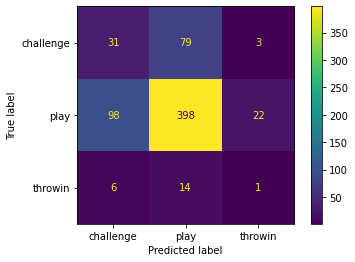


Classification Report
              precision    recall  f1-score   support

   challenge       0.23      0.27      0.25       113
        play       0.81      0.77      0.79       518
     throwin       0.04      0.05      0.04        21

    accuracy                           0.66       652
   macro avg       0.36      0.36      0.36       652
weighted avg       0.69      0.66      0.67       652



In [103]:
target_names = ['challenge', 'play', 'throwin']
print('Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(test_data.classes, y_pred, display_labels=target_names)
plt.show()
print('\nClassification Report')
print(classification_report(test_data.classes, y_pred, target_names=target_names))

In [85]:
model.save('/content/drive/MyDrive/Bundesliga/Models/model_ms4_1')

In [ ]:
# model = load_model('/content/drive/MyDrive/Bundesliga/Models/model_ms4_1')

2nd try:

In [113]:
model = create_model(with_dropout=True)
model = compile_model(model, lr=0.000001) # 6 decimals
model = train_model(model, epochs=10000, patience=50)

Epoch 1/10000
40/40 [==============================] - 38s 930ms/step - loss: 4.3029 - accuracy: 0.1463 - val_loss: 1.6051 - val_accuracy: 0.1388
Epoch 2/10000
40/40 [==============================] - 37s 926ms/step - loss: 3.7967 - accuracy: 0.1998 - val_loss: 1.3258 - val_accuracy: 0.1507
Epoch 3/10000
40/40 [==============================] - 37s 921ms/step - loss: 3.6749 - accuracy: 0.2611 - val_loss: 1.2247 - val_accuracy: 0.1699
Epoch 4/10000
40/40 [==============================] - 37s 921ms/step - loss: 3.6541 - accuracy: 0.2949 - val_loss: 1.1646 - val_accuracy: 0.2541
Epoch 5/10000
40/40 [==============================] - 37s 919ms/step - loss: 3.5211 - accuracy: 0.3276 - val_loss: 1.1230 - val_accuracy: 0.3013
Epoch 6/10000
40/40 [==============================] - 37s 922ms/step - loss: 3.5018 - accuracy: 0.3295 - val_loss: 1.0932 - val_accuracy: 0.3501
Epoch 7/10000
40/40 [==============================] - 37s 921ms/step - loss: 3.4139 - accuracy: 0.3720 - val_loss: 1.0737 -

In [13]:
batch_size = 16
num_of_test_samples = 652

Y_pred = model.predict_generator(test_data, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


Confusion Matrix


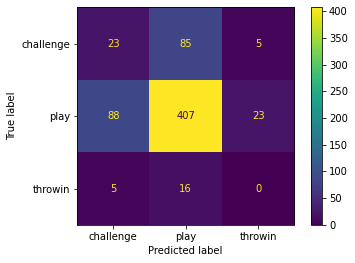


Classification Report
              precision    recall  f1-score   support

   challenge       0.20      0.20      0.20       113
        play       0.80      0.79      0.79       518
     throwin       0.00      0.00      0.00        21

    accuracy                           0.66       652
   macro avg       0.33      0.33      0.33       652
weighted avg       0.67      0.66      0.67       652



In [14]:
target_names = ['challenge', 'play', 'throwin']
print('Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(test_data.classes, y_pred, display_labels=target_names)
plt.show()
print('\nClassification Report')
print(classification_report(test_data.classes, y_pred, target_names=target_names))

In [19]:
from tqdm import tqdm

In [21]:
batch_size = 64

In [15]:
X_train, y_train = next(train_data)
X_val, y_val = next(valid_data)
X_test, y_test = next(test_data)

In [16]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((64, 224, 224, 3), (64, 224, 224, 3), (64, 224, 224, 3), (64,), (64,), (64,))

In [ ]:
y_pred_test = model.predict(X_test)
y_pred_test_b = [np.argmax(i, axis=0) for i in y_pred_test]
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_test_b)
plt.show()

In [33]:
y_pred = model.predict(test_data)
y_pred_b = np.array([np.argmax(i) for i in y_pred])

11/11 [==============================] - 3s 293ms/step


In [55]:
next(test_data)[1].tolist()

array([0., 2., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 2., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1.], dtype=float32)

In [56]:
y_true = list()
while True:
  y_true + next(test_data)[1].tolist()
y_true

KeyboardInterrupt: ignored

In [57]:
y_true

[]

In [40]:
y_pred_b

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 2, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 2,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,

In [36]:
IMAGES = 5
plt.figure(figsize=(20, 5))

for index in range(IMAGES):
  if y_pred_b[index] == 0:
    label = 'challenge'
    confidence = y_pred[index][0]
  else:
    label = 'cat'
    confidence = 1 - y_pred[index][0]

  plt.subplot(1, IMAGES, index + 1)
  plt.imshow(test_data[index][0])
  plt.title(f'Label: {label}\nConfidence = {confidence:.2%}', size=15)

In [39]:
y_pred_b.shape

(652,)

In [114]:
model.save('/content/drive/MyDrive/Bundesliga/Models/model_ms4_2')

In [12]:
model = load_model('/content/drive/MyDrive/Bundesliga/Models/model_ms4_2')